In [1]:
import pylab
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('D:/[Обучение]/ML/ДЗ 5 - ансамбли/ДЗ/train.csv')

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
#Заполняю определенными значениями те данные, которые "известны" (например, если в квартире нет балкона, ставлю его площадь нулевой)

data.LotFrontage.fillna(data.LotFrontage.median(), inplace=True)
data.MasVnrArea.fillna(0, inplace=True) 
data.GarageYrBlt.fillna(0, inplace=True)

In [6]:
#Перевожу даты в года

data['YearsBuilt']=2019-data['YearBuilt']
data['YearsRemodAdd']=2019-data['YearRemodAdd']
data = data.drop(['YearBuilt', 'YearRemodAdd'], axis=1)
Xtrain_prep=data.drop(['SalePrice'], axis=1)
Ytrain_prep = data['SalePrice']

In [7]:
# Поделим на train и тест
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xtrain_prep, Ytrain_prep, test_size=0.2)

In [8]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['Id', 'SalePrice'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = X_train[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          7
Exterior1st      13
Exterior2nd      15
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64


In [9]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(X_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(X_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]

In [10]:
#Т.к. алгоритмы у нас все метрические, то масштабирование применим уже здесь

from sklearn.preprocessing import StandardScaler

X_train_lin = pd.concat([X_train[num_feat],
                     X_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test_lin = pd.concat([X_test[num_feat],
                     X_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train_lin[num_feat])

X_train_lin[num_feat] = scaler.transform(X_train_lin[num_feat])
X_test_lin[num_feat] = scaler.transform(X_test_lin[num_feat])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


# А теперь смотрю, как работает дерево решений

In [11]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
regr = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=10)

In [13]:
#Оцениваем качество модели при помощи кросс-валидации

from sklearn.model_selection import cross_val_score
scores_train = cross_val_score(regr, X_train_lin, y_train, cv=10)

scores_train

array([0.77679338, 0.82104951, 0.8896349 , 0.81464015, 0.83115749,
       0.87235809, 0.84393719, 0.84088448, 0.50966931, 0.86252816])

In [14]:
scores_train.mean()

0.8062652663736462

In [15]:
regr.fit(X_train_lin, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
y_pred=regr.predict(X_test_lin)

In [17]:
#смотрю общий балл на тестовой выборке

regr.score(X_test_lin, y_test, sample_weight=None)

0.7551437688692799

In [18]:
#оцениваю важность признаков

imp = pd.Series(regr.feature_importances_)
imp.sort_values(ascending=False)

3      0.626659
13     0.112529
11     0.064294
9      0.042950
6      0.033281
23     0.017869
16     0.014901
10     0.012786
142    0.011414
24     0.006626
34     0.006544
2      0.005102
20     0.004238
254    0.003926
286    0.003768
153    0.003536
1      0.003501
35     0.003223
156    0.002641
299    0.002377
22     0.001971
218    0.001732
25     0.001430
21     0.001374
26     0.001198
4      0.000767
30     0.000661
239    0.000612
14     0.000596
210    0.000576
         ...   
219    0.000000
220    0.000000
221    0.000000
223    0.000000
212    0.000000
224    0.000000
225    0.000000
226    0.000000
227    0.000000
229    0.000000
230    0.000000
213    0.000000
211    0.000000
191    0.000000
199    0.000000
192    0.000000
193    0.000000
194    0.000000
195    0.000000
196    0.000000
197    0.000000
201    0.000000
209    0.000000
202    0.000000
203    0.000000
204    0.000000
205    0.000000
207    0.000000
208    0.000000
0      0.000000
Length: 321, dtype: floa

# Стекинг

In [19]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

In [20]:
from sklearn.linear_model import LinearRegression
model_LR = LinearRegression()

model_RF = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=10)

from sklearn import linear_model
model_SGD = linear_model.SGDRegressor( alpha = 0.01, max_iter = 1000 )

In [21]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555)

meta_train = []
meta_test = []
col_names = []

print('LR features...')
meta_tr, meta_te = get_meta_features(model_LR, X_train_lin, y_train, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(model_RF, X_train_lin, y_train, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')



LR features...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


RF features...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [22]:
#Здесь появится много предупреждений

print('SGD features...')
meta_tr, meta_te = get_meta_features(model_SGD, X_train_lin, y_train, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('SGD_pred')

SGD features...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infin

In [23]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

# Работа с мета-признаками

In [24]:
reg_lr_meta = LinearRegression()
reg_lr_meta.fit(X_meta_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [25]:
y_pred_meta_test=reg_lr_meta.predict(X_meta_test)

In [26]:
reg_lr_meta.score(X_meta_test, y_test)

0.7923219202745547

In [27]:
# Таким образом, точность алгоритма на тестовой выборке получилась больше, чем у Случайного леса

In [28]:
#Оцениваем качество модели при помощи кросс-валидации

from sklearn.model_selection import cross_val_score
scores_train = cross_val_score(reg_lr_meta, X_meta_train, y_train, cv=10)

scores_train

array([ 0.70826546,  0.75871723,  0.76183412,  0.81760395,  0.8236879 ,
        0.86063328,  0.80878707,  0.76725173, -0.14556597,  0.86455645])

In [29]:
scores_train.mean()

0.7025771206599039

In [30]:
#а вот на тренировочной выборке качество получилось почему-то хуже

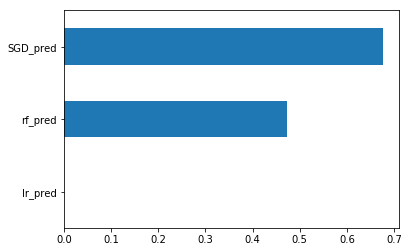

In [31]:
pd.Series(reg_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh')